# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

## **Edición 2024**


----

# Trabajo práctico entregable - parte 2


Trabajaremos con la base de datos de `melb_data` presentada a continuación.

In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')

In [ ]:
# Acá deberían leer el conjunto de datos que ya tienen.
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas.
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

melb_data_mice = melb_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_data_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_data_mice[['YearBuilt', 'BuildingArea']])

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Ejemplo de gráfico comparando las distribuciones de datos obtenidas con cada método de imputación.

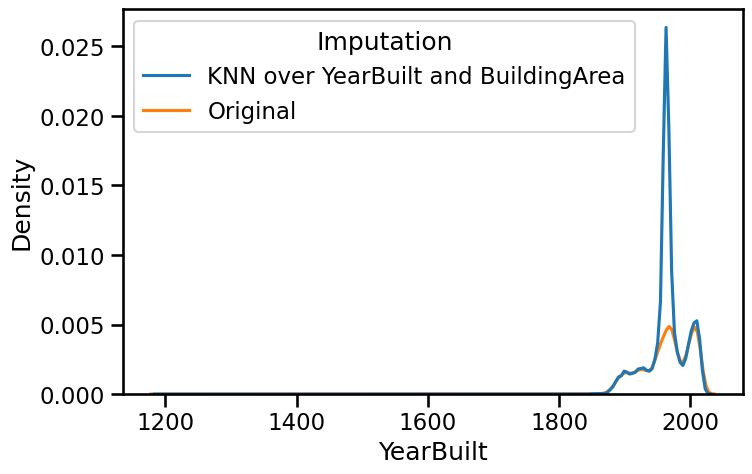

In [ ]:
mice_year_built = melb_data_mice.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_year_build = melb_df.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pandas.concat([mice_year_built, melb_year_build])
fig = plt.figure(figsize=(8, 5))
g = seaborn.kdeplot(data=data, x='YearBuilt', hue='Imputation')

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Seleccione las primeras $2$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [ ]:
## Small example
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## If we process our data with the following steps:
categorical_cols = ['Type', 'Regionname']
numerical_cols = ['Rooms', 'Distance']
new_columns = []

# Step 1: encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(melb_df[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 2: Append the numerical columns
X = numpy.hstack([X_cat, melb_df[numerical_cols].values])
new_columns.extend(numerical_cols)
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 3: Append some new features, like PCA
pca = PCA(n_components=2)
pca_dummy_features = pca.fit_transform(X)
X_pca = numpy.hstack([X, pca_dummy_features])
new_columns.extend(['pca1', 'pca2'])

## Re-build dataframe
processed_melb_df = pandas.DataFrame(data=X_pca, columns=new_columns)
processed_melb_df.head()

Matrix has shape (13580, 11), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria']
Matrix has shape (13580, 11), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria', 'Rooms', 'Distance']


,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria,Rooms,Distance,pca1,pca2
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.669418,-0.292703
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.669418,-0.292703
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.620201,0.619633
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.620201,0.619633
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.5,-7.570984,1.531969


## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de
     publicaciones de la plataforma AirBnB en el mismo código
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
